In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Предпросмотр данных
data_file=open('credit_card_default_analysis.csv', 'r')
data_file.readlines()[:10]

['ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default\n',
 '1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1\n',
 '2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1\n',
 '3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0\n',
 '4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0\n',
 '5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0\n',
 '6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0\n',
 '7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0\n',
 '8,100000,2,2,2,23,0,0,0,0,0,0,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0\n',
 '9,140000,2,3,1,28,

In [3]:
#Чтение данных
raw=pd.read_csv('credit_card_default_analysis.csv')
raw.shape

(30000, 25)

In [4]:
raw.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1

In [5]:
#Данные о кредитном лимите по группам
limit_d0=raw[raw.default==0].loc[:, 'LIMIT_BAL'].values
limit_d1=raw[raw.default==1].loc[:, 'LIMIT_BAL'].values
limit_d0.shape, limit_d1.shape

((23364L,), (6636L,))

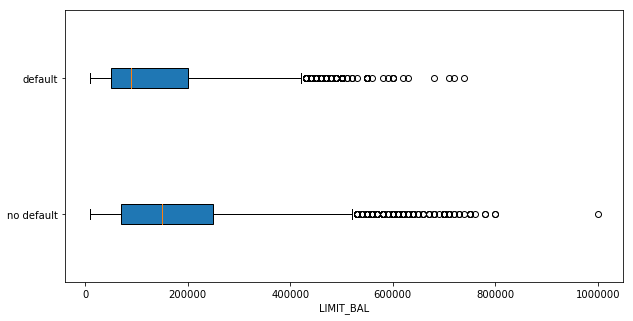

In [6]:
pylab.figure(figsize=(10, 5))
pylab.boxplot([limit_d0, limit_d1], vert=False, labels=['no default', 'default'], patch_artist=True)
pylab.xlabel('LIMIT_BAL')
pylab.show()

По графику видно, что медиана значения кредитного лимита группы вернувших кредит, больше медианы в группе не вернувших кредит. Однако интерквартильный размах групп пересекается.

1.1 Для определения доверительного интервала разности медианных значений и проверки гипотезы $H_0$: различия между медианными значениями отсутствуют, против двусторонней альтернативы $H_1$: различия присутствуют, используется бутстреп:

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices] #из одномерного списка в двухмерный при помощи маски индексов
    return samples

In [8]:
med_limit_d0=np.array(map(np.median, get_bootstrap_samples(limit_d0, 1000)))
med_limit_d1=np.array(map(np.median, get_bootstrap_samples(limit_d1, 1000)))

In [41]:
#Критерий Стьюдента для независимых выборок, состоящих из вещественных значений
print 'Уровень значимости H0:', stats.ttest_ind(med_limit_d0, med_limit_d1, equal_var=False)[1]

Уровень значимости H0: 0.0


$H_0$ о равенстве медианных значений отвергается на уровне значимости 0.05 в пользу $H_1$: различие между медианными значениями статистически значимо

Для оценки практической значимости различий строится доверительный интервал для разности между медианными значениями:

In [44]:
def conf_int(data, alpha):
    boundaries = np.percentile(data, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
conf_int(med_limit_d0-med_limit_d1, 0.05)

array([ 60000.,  70000.])

Границы доверительного интервала для разности между медианными значениями сопоставимы с самими медианными значениями, таким образом различие между медианными значениями в разных группах практически значимо.

1.2 Для проверки гипотезы  $H_0$ : равенство распределений, против двусторонней альтернативы  $H_1$ : распределения не равны, используется непараметрический перестановочный критерий для независимых выборок:

In [9]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [10]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [11]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [12]:
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
print 'Уровень значимости H0:', permutation_test(limit_d0, limit_d1, max_permutations = 10000)

0.0001

$H_0$ о равенстве распределений отвергается на уровне значимости 0.05 в пользу $H_1$: различие между распределениями статистически значимо.

# Задание 2

In [14]:
#Данные о поле по группам
default1_s=raw[raw.default==1].loc[:, 'SEX'].values-1 #Поправка на единицу, чтобы в дальнейшем считать долю женщин в группе
default0_s=raw[raw.default==0].loc[:, 'SEX'].values-1 #таким образом данные приводятся к выборкам из распределения Бернулли
default0_s.shape, default1_s.shape

((23364L,), (6636L,))

In [15]:
#Доля женщин в группах
default0_fem_prop=np.mean(default0_s)
default1_fem_prop=np.mean(default1_s)

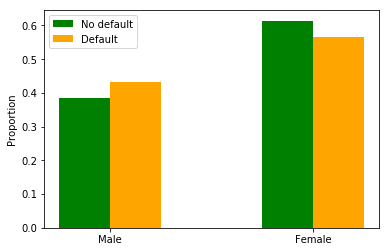

In [22]:
#Графики для доли мужчин и женщин в группах
bar_width=0.25
group_location=np.arange(2)
fig, ax = pylab.subplots()
bar_d0=ax.bar(group_location, [1-default0_fem_prop, default0_fem_prop], width=bar_width, color='green')
bar_d1=ax.bar(group_location+bar_width, [1-default1_fem_prop, default1_fem_prop], width=bar_width, color='orange')
ax.set_xticks(group_location+bar_width/2)
ax.set_xticklabels(('Male', 'Female'))
ax.legend((bar_d0, bar_d1), ('No default', 'Default'))
ax.set_ylabel('Proportion')
pylab.show()

По графику видно, что доля мужчин в группе не вернувших кредит выше, чем доля мужчин в группе вернувших кредит

2.1 Определение доверительного интервала разности долей в независимых выборках

In [16]:
#Доверительный интервал для разности долей независимых выборок
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [17]:
#Доверительный интервал разности долей
proportions_diff_confint_ind(default1_s, default0_s) 

(-0.060548077974896725, -0.033634932749628671)

0 не находится в 95% доверительном интервале разности долей, следовательно гендерный состав отличается (доля женщин в группе не вернувших кредит меньше, чем доля женщин в группе вернувших кредит)

2.2 Проверка гипотезы $H_0$: гендерный состав не отличается, против двусторонней альтернативы $H_1$:гендерный состав отличается

In [18]:
#Функция для вычисления Z-статистики для разностей долей в независимых выборках
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [19]:
#Значение Z-статистики
Z=proportions_diff_z_stat_ind(default1_s, default0_s)

In [20]:
#Функция для вычисления уровеня значимости нулевой гипотезы
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [30]:
print 'Уровень значимости H0:', proportions_diff_z_test(Z)

Уровень значимости H0: 4.47286652161e-12


$H_0$ о равенстве гендерного состава отвергается на уровне значимости 0.05 в пользу $H_1$: гендерный состав групп вернувших кредит и не вернувших состав отличается

# Задание 3

In [22]:
#Таблица сопряженности признаков "образование" и "дефолт"
observed_frequency=pd.crosstab(raw.EDUCATION, raw.default)
observed_frequency

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


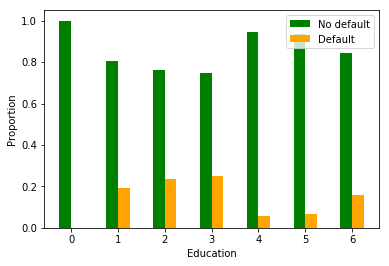

In [23]:
#Графики для доли заемщиков, вернувших не вернувших кредит, по группам
bar_width=0.25
group_location=np.arange(observed_frequency.shape[0])
fig, ax = pylab.subplots()
bar_d0=ax.bar(group_location, observed_frequency.iloc[:, 0]/observed_frequency.sum(axis=1),\
              width=bar_width, color='green')
bar_d1=ax.bar(group_location+bar_width, observed_frequency.iloc[:, 1]/observed_frequency.sum(axis=1),\
              width=bar_width, color='orange')
ax.set_xticks(group_location+bar_width/2)
ax.set_xticklabels(observed_frequency.index)
ax.legend((bar_d0, bar_d1), ('No default', 'Default'))
ax.set_xlabel('Education')
ax.set_ylabel('Proportion')
pylab.show()

По графику видно, что для группы заемщиков с образованием "доктор" доля вернувших кредит, наиболее высокая, а для группы заемщиков с образованием "выпускник школы", наиболее низкая.

Проверка гипотезы $H_0$: признаки "образование" и "дефолт" не зависят друг от друга, против двусторонней альтернативы $H_1$: признаки "образование" и "дефолт" зависят друг от друга

In [28]:
print "Уровень значимости H0:", stats.chi2_contingency(observed_frequency)[1]

Уровень значимости H0: 1.23326262454e-32


$H_0$ о независимости признаков отвергается на уровне значимости 0.05 в пользу $H_1$: признаки "образование" и "дефолт" зависят друг от друга

In [25]:
#Ожидаемые значения при истинности нулевой гипотезы
expected_frequency=stats.chi2_contingency(observed_frequency)[3]

In [26]:
#Отклонение ожидаемых и наблюдаемых частот в таблице сопряженности
observed_frequency-expected_frequency

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


In [27]:
#Размеры групп по образованию
nis=observed_frequency.sum(axis=1)
#Отклонение, отмасштабированное с учетом размера групп по уровню образования
(observed_frequency-expected_frequency)/np.column_stack((nis.values, nis.values))

default,0,1
EDUCATION,,
0,0.221200,-0.221200
1,0.028852,-0.028852
2,-0.016149,0.016149
3,-0.030376,0.030376
4,0.164289,-0.164289
5,0.156914,-0.156914
6,0.064337,-0.064337


Чем больше наблюдаемое отклонение от нулевого распределения, тем показательнее положительная взаимосвязь между определенными уровнями признаков.
Выводы по данным отмасштабированной таблицы:
Для группы, вернувших кредит наиболее показательным уровнем образования является доктор (0).
Для группы, не вернувших кредит наиболее показательным уровнем образования является выпускник школы (3).

# Задание 4

В качестве меры взаимосвязи категориальных переменных используется коэффициент V Крамера.

In [32]:
#Таблица сопряженности признака "семейное положение" и "дефолт"
observed_mar_frequency=pd.crosstab(raw.MARRIAGE, raw.default)
observed_mar_frequency

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


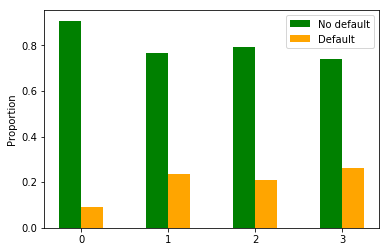

In [33]:
#Графики для доли заемщиков, вернувших не вернувших кредит, по группам
bar_width=0.25
group_location=np.arange(observed_mar_frequency.shape[0])
fig, ax = pylab.subplots()
bar_d0=ax.bar(group_location, observed_mar_frequency.iloc[:, 0]/observed_mar_frequency.sum(axis=1),\
              width=bar_width, color='green')
bar_d1=ax.bar(group_location+bar_width, observed_mar_frequency.iloc[:, 1]/observed_mar_frequency.sum(axis=1),\
              width=bar_width, color='orange')
ax.set_xticks(group_location+bar_width/2)
ax.set_xticklabels(observed_mar_frequency.index)
ax.legend((bar_d0, bar_d1), ('No default', 'Default'))
ax.set_ylabel('Proportion')
pylab.show()

По графику видно, что для группы заемщиков, отказавшихся отвечать о семейном положени, доля невернувших кредит наиболее низкая, чем доля не вернувших кредит в остальных группах, остальные доли не вернувших кредит примерно равны.

In [34]:
#Значение статистики хи-квадрат
chi2_mar=stats.chi2_contingency(observed_mar_frequency)[0]
#Количество уровней признаков
K=observed_mar_frequency.shape[0]
L=observed_mar_frequency.shape[1]
#Количество объектов
n=observed_mar_frequency.sum().sum()

In [35]:
phi_c=(chi2_mar/(n*(min(K, L)-1)))**0.5
print "Коэффициент V Крамера", phi_c

Коэффициент V Крамера 0.0344782036628


Признаки "семейное положение" и "дефолт" связаны слабо

# Задание 5

In [37]:
#Данные о кредитном лимите по группам
age_d0=raw[raw.default==0].loc[:, 'AGE'].values
age_d1=raw[raw.default==1].loc[:, 'AGE'].values
age_d0.shape, age_d1.shape

((23364L,), (6636L,))

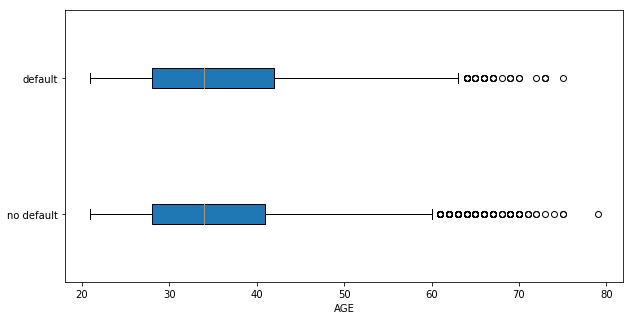

In [38]:
pylab.figure(figsize=(10, 5))
pylab.boxplot([age_d0, age_d1], vert=False, labels=['no default', 'default'], patch_artist=True)
pylab.xlabel('AGE')
pylab.show()

По графику видно, что медиана значения возраста группы вернувших кредит примерно равна медиане возраста группы не вернувших кредит, интерквартильный размах групп пересекается.

5.1 Для определения доверительного интервала медианных значений и проверки гипотезы $H_0$: различия между медианными значениями отсутствуют, против двусторонней альтернативы $H_1$: различия присутствуют, используется бутстреп:

In [39]:
med_age_d0=np.array(map(np.median, get_bootstrap_samples(age_d0, 1000)))
med_age_d1=np.array(map(np.median, get_bootstrap_samples(age_d1, 1000)))

In [42]:
#Критерий Стьюдента для независимых выборок, состоящих из вещественных значений
print 'Уровень значимости H0:', stats.ttest_ind(med_age_d0, med_age_d1, equal_var=False)[1]

Уровень значимости H0: 1.91821386797e-24


Для оценки практической значимости различий строится доверительный интервал для разности между медианными значениями:

In [45]:
conf_int(med_age_d0-med_age_d1, 0.05)

array([-1.,  0.])

Границы доверительного интервала для разности между медианными значениями значительно меньше медианных значений, таким образом различие между медианными значениями в разных группах практически не значимо.

5.2 Для проверки гипотезы  $H_0$ : равенство распределений, против двусторонней альтернативы  $H_1$ : распределения не равны, используется непараметрический перестановочный критерий независимых выборок:

In [46]:
print 'Уровень значимости H0:', permutation_test(age_d0, age_d1, max_permutations = 10000)

Уровень значимости H0: 0.0172


$H_0$ о равенстве распределений отвергается на уровне значимости 0.05 в пользу $H_1$: различие между распределениями статистически значимо.